In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import tensorflow as tf
import PIL
import cPickle, os

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
DATA_DIR = '../data/observed/'
f = open('labels.pkl', 'r')
labels = cPickle.load(f)
filelist = [DATA_DIR + L for L in labels.keys()]

In [4]:
# Build input vectors
HALF_SZ = 32
backs = []
other = []

for f in filelist:
    im = np.array(PIL.Image.open(f))
    lbls = labels[os.path.basename(f)]
    for x,y in lbls:
        backs.append(im[y-HALF_SZ:y+HALF_SZ,x-HALF_SZ:x+HALF_SZ])
    for _ in range(2):
        y = np.random.randint(HALF_SZ, im.shape[0]-HALF_SZ)
        x = np.random.randint(HALF_SZ, im.shape[1]-HALF_SZ)
        dist = [(x-x0)**2+(y-y0)**2 for x0,y0 in lbls]
        if len(dist) > 0 and min(dist) < HALF_SZ**2:
            continue
        other.append(im[y-HALF_SZ:y+HALF_SZ,x-HALF_SZ:x+HALF_SZ])

backs = np.array(backs, dtype=np.float32) / 255
other = np.array(other, dtype=np.float32) / 255
print backs.shape, other.shape

(615, 64, 64, 3) (1487, 64, 64, 3)


In [5]:
HALF_SZ = 32

def flipped_permutations(img):
    rv = []
    for im in (img, np.rot90(img)):
        for i in (im, np.flipud(im)):
            rv.append(i)
            rv.append(np.fliplr(i))
    return rv
    
backs = []
other = []
for cnt,f in enumerate(filelist):
    #if cnt % 8 != 0: continue
    if cnt % 70 == 0:
        print cnt, len(filelist)
    im = np.array(PIL.Image.open(f))
    lbls = labels[os.path.basename(f)]
    for cy in range(HALF_SZ, im.shape[0]-HALF_SZ/2, HALF_SZ/2):
        for cx in range(HALF_SZ, im.shape[1]-HALF_SZ/2, HALF_SZ/2):
            clip = im[cy-HALF_SZ:cy+HALF_SZ,cx-HALF_SZ:cx+HALF_SZ]
            dist = [(cx-x0)**2+(cy-y0)**2 for x0,y0 in lbls]
            if len(dist) > 0 and min(dist) < (0.5 * HALF_SZ)**2:
                backs += flipped_permutations(clip)
            elif len(dist) == 0 or min(dist) > (1.5 * HALF_SZ)**2:
                if cnt % 16 != 0: continue
                other += flipped_permutations(clip)
                
print len(backs), len(other)
backs = np.array(backs, dtype=np.float32) / 255
other = np.array(other, dtype=np.float32) / 255
print backs.shape, other.shape

0 768
70 768
140 768
210 768
280 768
350 768
420 768
490 768
560 768
630 768
700 768
15312 99992
(15312, 64, 64, 3) (99992, 64, 64, 3)


In [ ]:
print np.array(backs, dtype=np.float32).shape

In [12]:
#import random
#random.shuffle(backs)
#random.shuffle(other)
NTEST = 100
train_x = np.concatenate([backs[:-NTEST], other[:-NTEST]], axis=0)
NBACKS = len(backs[:-NTEST])
train_y = np.zeros((train_x.shape[0],2), dtype=np.float32)
train_y[:NBACKS,0] = 1
train_y[NBACKS:,1] = 1
test_x = np.concatenate([backs[-NTEST:], other[-NTEST:]], axis=0)
test_y = np.zeros((2*NTEST,2), dtype=np.float32)
test_y[:NTEST,0] = 1
test_y[NTEST:,1] = 1
print train_x.shape, test_x.shape

(115104, 64, 64, 3) (200, 64, 64, 3)


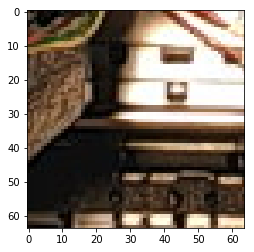

In [39]:
plt.figure()
plt.imshow(other[10])
plt.show()

In [7]:
# Define NN

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

IMG_SIZE = HALF_SZ * 2
x = tf.placeholder(tf.float32, shape=[None, IMG_SIZE, IMG_SIZE, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 2])

# The convolution will compute 32 features for each 5x5 patch. 
# Its weight tensor will have a shape of [5, 5, 1, 32]. 
# The first two dimensions are the patch size, the next is the number of 
# input channels, and the last is the number of output channels. 
W_conv1 = weight_variable([5, 5, 3, 32])
b_conv1 = bias_variable([32])

# To apply the layer, we first reshape x to a 4d tensor, 
# with the second and third dimensions corresponding to image width and height, 
# and the final dimension corresponding to the number of color channels.
x_image = tf.reshape(x, [-1, IMG_SIZE, IMG_SIZE, 3])

# We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, 
# and finally max pool. The max_pool_2x2 method will reduce the image size to IMG_SIZE/2
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
print h_pool1.shape

# In order to build a deep network, we stack several layers of this type. 
# The second layer will have 64 features for each 5x5 patch.
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
print h_pool2.shape

# Now that the image size has been reduced to 7x7, we add a fully-connected 
# layer with 1024 neurons to allow processing on the entire image. We reshape 
# the tensor from the pooling layer into a batch of vectors, multiply 
# by a weight matrix, add a bias, and apply a ReLU.
W_fc1 = weight_variable([16 * 16 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 16 * 16 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# To reduce overfitting, we will apply dropout before the readout layer. We
# create a placeholder for the probability that a neuron's output is kept
# during dropout. This allows us to turn dropout on during training, and turn
# it off during testing. TensorFlow's tf.nn.dropout op automatically handles
# scaling neuron outputs in addition to masking them, so dropout just works
# without any additional scaling.
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])

h_fc = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
#y_conv = 0.5 * tf.tanh(h_fc) + 0.5
y_conv = h_fc
print y_conv.shape

(?, 32, 32, 32)
(?, 16, 16, 64)
(?, 2)


In [22]:
# Train the NN

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

NCYCLES = 200
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(NCYCLES):
        backs_ratio = max(.5 - float(i)/NCYCLES, .15)
        NSAMP = 50
        batch = np.concatenate([np.random.randint(NBACKS, size=int(NSAMP*backs_ratio)), np.random.randint(NBACKS,train_x.shape[0], size=int(NSAMP*(1-backs_ratio)))])
        if i % 10 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: train_x[batch], y_: train_y[batch], keep_prob: 1.0})
            print(i, backs_ratio)
            print('step %d, training accuracy %g' % (i, train_accuracy))
            #print train_y[batch].flatten()
            #print y_conv.eval(feed_dict={x: train_x[batch], y_: train_y[batch], keep_prob: 1.0}).flatten()
            saver.save(sess, os.path.join(os.getcwd(),"mtg_back000.ckpt"))
        train_step.run(feed_dict={x: train_x[batch], y_: train_y[batch], keep_prob: 0.5})

(0, 0.5)
step 0, training accuracy 0.52
(10, 0.45)
step 10, training accuracy 0.734694
(20, 0.4)
step 20, training accuracy 0.72
(30, 0.35)
step 30, training accuracy 0.795918
(40, 0.3)
step 40, training accuracy 0.88
(50, 0.25)
step 50, training accuracy 0.816327
(60, 0.2)
step 60, training accuracy 0.98
(70, 0.15000000000000002)
step 70, training accuracy 0.877551
(80, 0.15)
step 80, training accuracy 0.918367
(90, 0.15)
step 90, training accuracy 0.897959
(100, 0.15)
step 100, training accuracy 0.897959
(110, 0.15)
step 110, training accuracy 0.938776
(120, 0.15)
step 120, training accuracy 0.979592
(130, 0.15)
step 130, training accuracy 0.938776
(140, 0.15)
step 140, training accuracy 0.918367
(150, 0.15)
step 150, training accuracy 0.918367
(160, 0.15)
step 160, training accuracy 0.918367
(170, 0.15)
step 170, training accuracy 0.979592
(180, 0.15)
step 180, training accuracy 0.918367
(190, 0.15)
step 190, training accuracy 0.959184


In [23]:
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, "mtg_back000.ckpt")
    print('test accuracy %g' % accuracy.eval(feed_dict={x: test_x, y_: test_y, keep_prob: 1.0}))
    k = session.run([tf.nn.softmax(y_conv)], feed_dict={x:test_x , keep_prob: 1.})

INFO:tensorflow:Restoring parameters from mtg_back000.ckpt
test accuracy 0.82


In [109]:
np.around(k, 1)[0,27]

array([0.2, 0.8], dtype=float32)

[0. 1.]


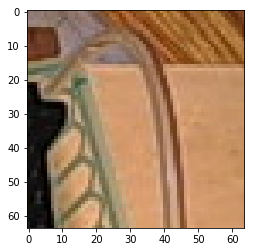

In [24]:
CNT = 109
print np.around(k, 1)[0,CNT]
plt.figure()
plt.imshow(test_x[CNT])
plt.show()

In [14]:
#f = DATA_DIR + 'tmpxXjUhN'
f = DATA_DIR + 'tmpwCIGAG'

In [24]:
with tf.Session() as session:
    saver.restore(session, "mtg_back000.ckpt")
    input_x = []
    centers = []
    for cy in range(HALF_SZ, im.shape[0], HALF_SZ):
        for cx in range(HALF_SZ, im.shape[1], HALF_SZ):
            sub_im = im[cy-HALF_SZ:cy+HALF_SZ,cx-HALF_SZ:cx+HALF_SZ]
            input_x.append(sub_im)
            centers.append((cx,cy))
    input_x = np.array(input_x)
    k = session.run([tf.nn.softmax(y_conv)], feed_dict={x:test_x , keep_prob: 1.})

INFO:tensorflow:Restoring parameters from mtg_back000.ckpt


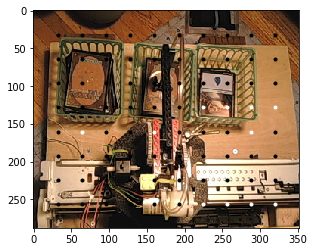

In [25]:
plt.figure()
plt.imshow(im)
for (cx,cy),is_other in zip(centers, np.argmax(np.array(k)[0], 1)):
    if is_other: plt.plot(cx, cy, 'w.')
    else: plt.plot(cx, cy, 'k.')

[1. 0.]


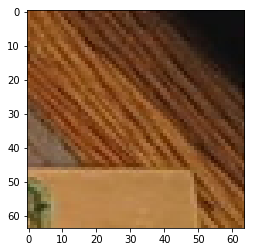

In [30]:
CNT = 9
print np.around(k, 1)[0,CNT]
plt.figure()
plt.imshow(input_x[CNT])
